# Lung Tumor Detection and Segmentation [Training]

In [7]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

- Read The images, masks, and detections

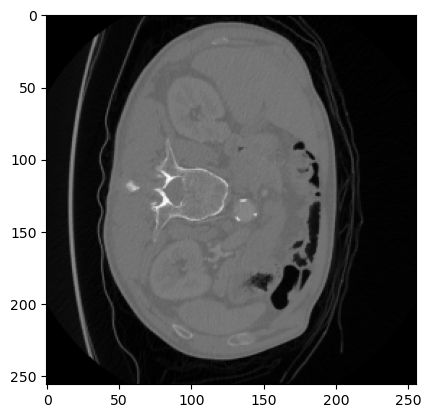

In [ ]:
train_path = './dataset/train/'
images = []
for patient in os.listdir(os.path.join(train_path, 'images/')):
    for image_name in os.listdir(os.path.join(train_path, 'images/', patient)):
        images.append(cv2.imread(os.path.join(train_path, 'images/', patient, image_name), cv2.IMREAD_COLOR))
plt.imshow(images[0])
plt.show()